In [1]:
%cd torchspdnet_untouched 

import os, sys
sys.path.append(os.getcwd())

/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/torchspdnet_untouched


In [2]:
# Preliminaries 
import numpy as np
import pandas as pd
import time

from random import randint
import os
import shutil

from numpy import sqrt 
import torch as th
from scipy.stats import t
import sys
from random import randint
from datetime import datetime
from datetime import timedelta
import missingno as msno

# Enable anomaly detection
th.autograd.set_detect_anomaly(True)

import fastcluster
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

from scipy.stats import rankdata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import random

import torch.nn as nn
from torch.utils import data

import torchspdnet.nn as spdnet
from torchspdnet.optimizers import MixOptimizer

from collections import Counter

In [3]:
# Define the relative paths for each category
data_paths = {
    'stressed': 'stressed_mats_top60',
    'normal': 'normal_mats_top60',
    'rally': 'rally_mats_top60'
}

# Assign labels to each category
labels = {'stressed': 0, 'normal': 1, 'rally': 2}

# Initialize lists for storing data and labels
all_matrices = []
all_labels = []

for category, rel_path in data_paths.items():
    full_path = os.path.join(os.getcwd(), rel_path)
    category_count = 0
    for filename in os.listdir(full_path):
        if filename.endswith('.npy'):
            matrix = np.load(os.path.join(full_path, filename))
            all_matrices.append(matrix)
            all_labels.append(labels[category])
            category_count += 1
    print(f'Category: {category}, Count: {category_count}')

# Combine matrices and labels into a single list of tuples and shuffle
combined_data = list(zip(all_matrices, all_labels))
random.Random(0).shuffle(combined_data)

# Unzip the shuffled data
shuffled_matrices, shuffled_labels = zip(*combined_data)

print(f'Total number of matrices: {len(shuffled_matrices)}')

Category: stressed, Count: 6000
Category: normal, Count: 6000
Category: rally, Count: 6000
Total number of matrices: 18000


In [4]:
# Check the shape of the first few matrices
for i, matrix in enumerate(shuffled_matrices):
    if i < 5:  # Check the first 5 matrices
        print(f'Matrix {i} shape: {matrix.shape}')

Matrix 0 shape: (60, 60)
Matrix 1 shape: (60, 60)
Matrix 2 shape: (60, 60)
Matrix 3 shape: (60, 60)
Matrix 4 shape: (60, 60)


In [5]:
class DatasetCorrMats(data.Dataset):
    def __init__(self, matrices, labels):
        self.matrices = matrices
        self.labels = labels

    def __len__(self):
        return len(self.matrices)

    def __getitem__(self, idx):
        # Load the matrix and convert to torch tensor
        x = th.from_numpy(self.matrices[idx]).double()
        x = x[None, :, :].real  # Add a new dimension and take the real part

        # Get the label and convert to long tensor
        y = th.tensor(self.labels[idx], dtype=th.long)

        return x, y

In [6]:
class CorrMatsNet(nn.Module):
    def __init__(self, bn=False):
        super(__class__, self).__init__()
        dim = 60
        dim1 = 20
        classes = 3
        self._bn = bn
        self.bimap1 = spdnet.BiMap(1, 1, dim, dim1)
        if bn:
            self.batchnorm1 = spdnet.BatchNormSPD(dim1)
        self.logeig = spdnet.LogEig()
        self.linear = nn.Linear(dim1**2, classes).double()
    def forward(self, x):
        x = self.bimap1(x)
        if self._bn:
            x = self.batchnorm1(x)
        x = self.logeig(x)
        x_vec = x.view(x.shape[0], -1)
        y = self.linear(x_vec)
        return y

In [7]:
def train_model(train_generator, test_generator, use_rbn=True,
                batch_size=30, lr=1e-2, threshold_reeig = 1e-4, epochs=30,
                n=60, C=3):

  model = CorrMatsNet(bn=use_rbn)

  loss_fn = nn.CrossEntropyLoss()
  opti = MixOptimizer(model.parameters(),lr=lr)

  #initial validation accuracy
  loss_val, acc_val = [], []
  y_true, y_pred = [], []
  model.eval()
  for local_batch, local_labels in test_generator:
      out = model(local_batch)
      l = loss_fn(out, local_labels)
      predicted_labels=out.argmax(1)
      y_true.extend(list(local_labels.cpu().numpy()))
      y_pred.extend(list(predicted_labels.cpu().numpy()))
      acc, loss = ((predicted_labels==local_labels)
                  .cpu()
                  .numpy()
                  .sum()/out.shape[0],
                  l.cpu().data.numpy())
      loss_val.append(loss)
      acc_val.append(acc)
  acc_val = np.asarray(acc_val).mean()
  loss_val = np.asarray(loss_val).mean()
  print('Initial validation accuracy: ' + str(round(100 * acc_val, 2)) + '%')
  spdnet_acc = []
  spdnet_acc.append(acc_val)

  #training loop
  for epoch in range(epochs):

      # train one epoch
      loss_train, acc_train = [], []
      model.train()
      for local_batch, local_labels in train_generator:
          opti.zero_grad()
          out = model(local_batch)
          l = loss_fn(out, local_labels)
          acc, loss = ((out.argmax(1) == local_labels)
                      .cpu()
                      .numpy()
                      .sum()/out.shape[0],
                      l.cpu().data.numpy())
          loss_train.append(loss)
          acc_train.append(acc)
          l.backward()
          opti.step()
      acc_train = np.asarray(acc_train).mean()
      loss_train = np.asarray(loss_train).mean()

      # validation
      acc_val_list = []
      loss_val_list = []
      y_true, y_pred = [], []
      model.eval()
      for local_batch, local_labels in test_generator:
          out = model(local_batch)
          l = loss_fn(out, local_labels)
          predicted_labels = out.argmax(1)
          y_true.extend(list(local_labels.cpu().numpy()))
          y_pred.extend(list(predicted_labels.cpu().numpy()))
          acc, loss = ((predicted_labels == local_labels)
                      .cpu()
                      .numpy()
                      .sum()/out
                      .shape[0], 
                      l.cpu().data.numpy())
          acc_val_list.append(acc)
          loss_val_list.append(loss)
      acc_val = np.asarray(acc_val_list).mean()
      loss_val = np.asarray(loss_val_list).mean()

      if (epoch + 1) % 10 == 0:
        print('Val acc: ' + str(round(100 * acc_val, 2)) + '% at epoch ' +
              str(epoch + 1) + '/' + str(epochs))

      spdnet_acc.append(acc_val)

  return spdnet_acc, model

In [8]:
acc_results = []
std_results = []
batch_size = 32
train_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200]
for use_rbn in [True, False]:
    for train_size in train_sizes:
        print(f'Train sample size: {train_size} with RBN={use_rbn}')

        # Calculate class cardinality
        for id_class in range(3):
            class_card = sum(1 for label in shuffled_labels[:train_size] if label == id_class)
            print(f'Class {id_class} cardinal = {class_card}')

        # Create dataset instances
        train_set = DatasetCorrMats(shuffled_matrices[:train_size], shuffled_labels[:train_size])
        test_set = DatasetCorrMats(shuffled_matrices[-1000:], shuffled_labels[-1000:])

        # DataLoader instances
        train_generator = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        test_generator = data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

        test_accuracy, model = train_model(train_generator, test_generator, use_rbn=use_rbn)
    
        acc_results.append(test_accuracy)
    
acc_results = np.array(acc_results)

Train sample size: 100 with RBN=True
Class 0 cardinal = 23
Class 1 cardinal = 45
Class 2 cardinal = 32
Initial validation accuracy: 33.5%
Val acc: 37.7% at epoch 10/30
Val acc: 35.16% at epoch 20/30
Val acc: 36.43% at epoch 30/30
Train sample size: 200 with RBN=True
Class 0 cardinal = 60
Class 1 cardinal = 78
Class 2 cardinal = 62
Initial validation accuracy: 32.13%
Val acc: 42.97% at epoch 10/30
Val acc: 50.2% at epoch 20/30
Val acc: 58.11% at epoch 30/30
Train sample size: 300 with RBN=True
Class 0 cardinal = 95
Class 1 cardinal = 105
Class 2 cardinal = 100
Initial validation accuracy: 35.64%
Val acc: 65.43% at epoch 10/30
Val acc: 68.75% at epoch 20/30
Val acc: 69.73% at epoch 30/30
Train sample size: 400 with RBN=True
Class 0 cardinal = 131
Class 1 cardinal = 133
Class 2 cardinal = 136
Initial validation accuracy: 30.08%
Val acc: 61.43% at epoch 10/30
Val acc: 65.92% at epoch 20/30
Val acc: 68.36% at epoch 30/30
Train sample size: 500 with RBN=True
Class 0 cardinal = 165
Class 1 ca

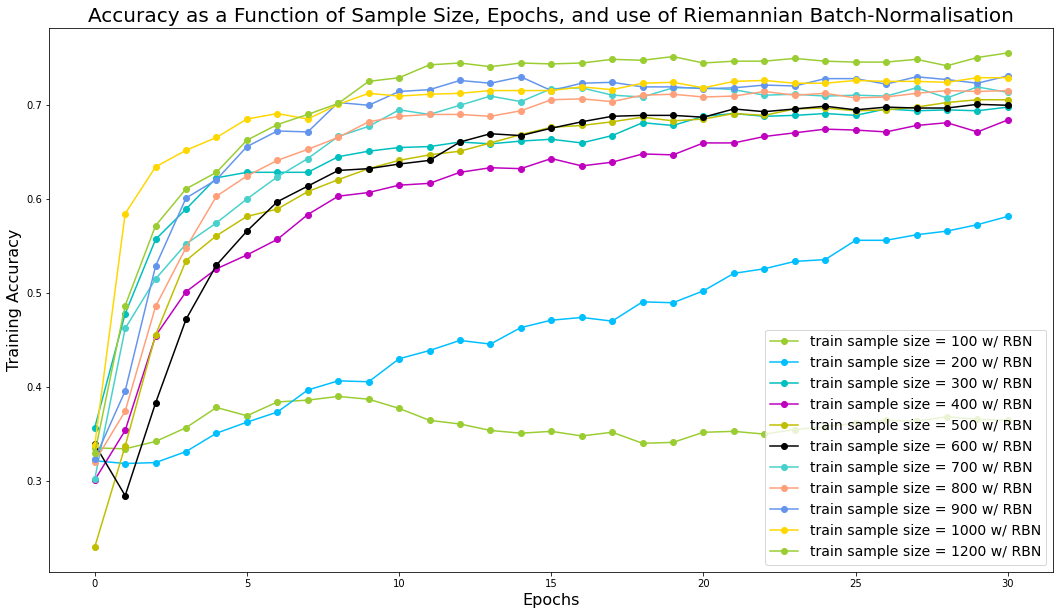

In [9]:
# Plotting
plt.figure(figsize=(18, 10))
colors = ['yellowgreen', 'deepskyblue', 'c', 'm', 'y', 'k', 'mediumturquoise', 'lightsalmon', 'cornflowerblue', 'gold']
for i, train_size in enumerate(train_sizes):
    plt.plot(acc_results[i, :], '-o', color=colors[i % len(colors)],
             label=f'train sample size = {train_size} w/ RBN')

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Training Accuracy', fontsize=12)
#plt.title('Accuracy as a Function of Sample Size, Epochs, and use of Riemannian Batch-Normalisation', fontsize=20)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.savefig('accuracy_plot_top60_userbn_true_100.png', bbox_inches='tight')
plt.show()



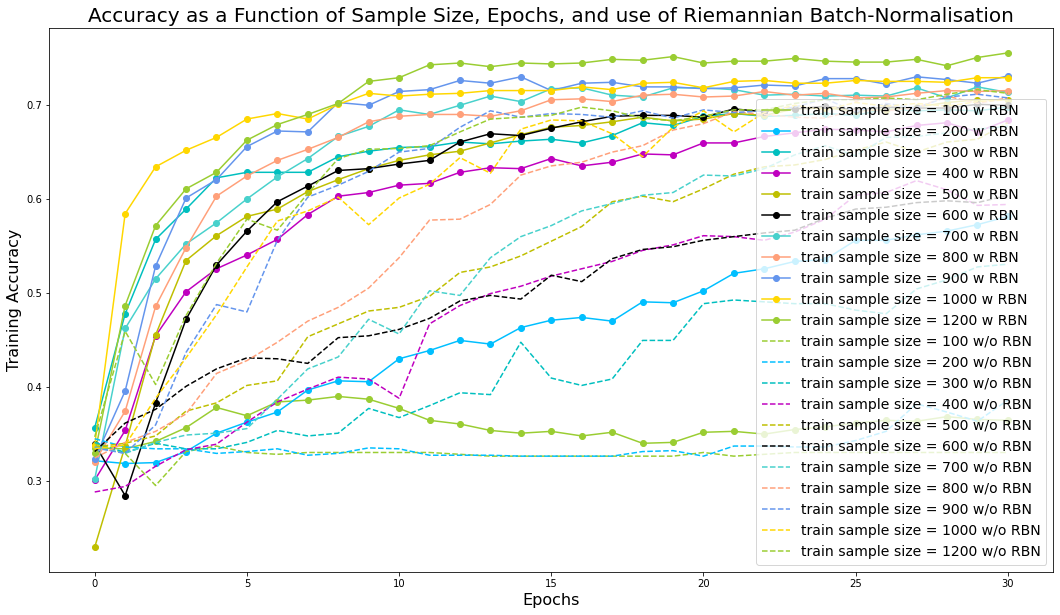

In [10]:
plt.figure(figsize=(18, 10))
#colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
colors = ['yellowgreen', 'deepskyblue', 'c', 'm', 'y', 'k', 'mediumturquoise', 'lightsalmon', 'cornflowerblue', 'gold']
for i, train_size in enumerate(train_sizes):
  plt.plot(acc_results[i, :], '-o', color=colors[i % len(colors)],
           label=f'train sample size = {train_size} w RBN')
for i, train_size in enumerate(train_sizes):
  plt.plot(acc_results[i + len(train_sizes), :], '--',
           color=colors[i % len(colors)],
           label=f'train sample size = {train_size} w/o RBN')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Training Accuracy', fontsize=12)
#plt.title('Accuracy as a Function of Sample Size, Epochs, ' +
          'and use of Riemannian Batch-Normalisation', fontsize=20)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.savefig('accuracy_plot_top60_both_100.png', bbox_inches='tight')
plt.show()

In [11]:
acc_results = []
std_results = []
batch_size = 32
train_sizes = [500,800,1000,1200,1500]
for use_rbn in [True, False]:
    for train_size in train_sizes:
        print(f'Train sample size: {train_size} with RBN={use_rbn}')

        # Calculate class cardinality
        for id_class in range(3):
            class_card = sum(1 for label in shuffled_labels[:train_size] if label == id_class)
            print(f'Class {id_class} cardinal = {class_card}')

        # Create dataset instances
        train_set = DatasetCorrMats(shuffled_matrices[:train_size], shuffled_labels[:train_size])
        test_set = DatasetCorrMats(shuffled_matrices[-1500:], shuffled_labels[-1500:])

        # DataLoader instances
        train_generator = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        test_generator = data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

        test_accuracy, model = train_model(train_generator, test_generator, use_rbn=use_rbn)
    
        acc_results.append(test_accuracy)
    
acc_results = np.array(acc_results)

Train sample size: 500 with RBN=True
Class 0 cardinal = 165
Class 1 cardinal = 166
Class 2 cardinal = 169
Initial validation accuracy: 23.5%
Val acc: 65.19% at epoch 10/30
Val acc: 69.24% at epoch 20/30
Val acc: 69.64% at epoch 30/30
Train sample size: 800 with RBN=True
Class 0 cardinal = 248
Class 1 cardinal = 279
Class 2 cardinal = 273
Initial validation accuracy: 32.08%
Val acc: 68.36% at epoch 10/30
Val acc: 69.8% at epoch 20/30
Val acc: 72.06% at epoch 30/30
Train sample size: 1000 with RBN=True
Class 0 cardinal = 293
Class 1 cardinal = 342
Class 2 cardinal = 365
Initial validation accuracy: 34.65%
Val acc: 69.33% at epoch 10/30
Val acc: 70.2% at epoch 20/30
Val acc: 71.22% at epoch 30/30
Train sample size: 1200 with RBN=True
Class 0 cardinal = 353
Class 1 cardinal = 420
Class 2 cardinal = 427
Initial validation accuracy: 35.58%
Val acc: 70.85% at epoch 10/30
Val acc: 73.51% at epoch 20/30
Val acc: 75.37% at epoch 30/30
Train sample size: 1500 with RBN=True
Class 0 cardinal = 452


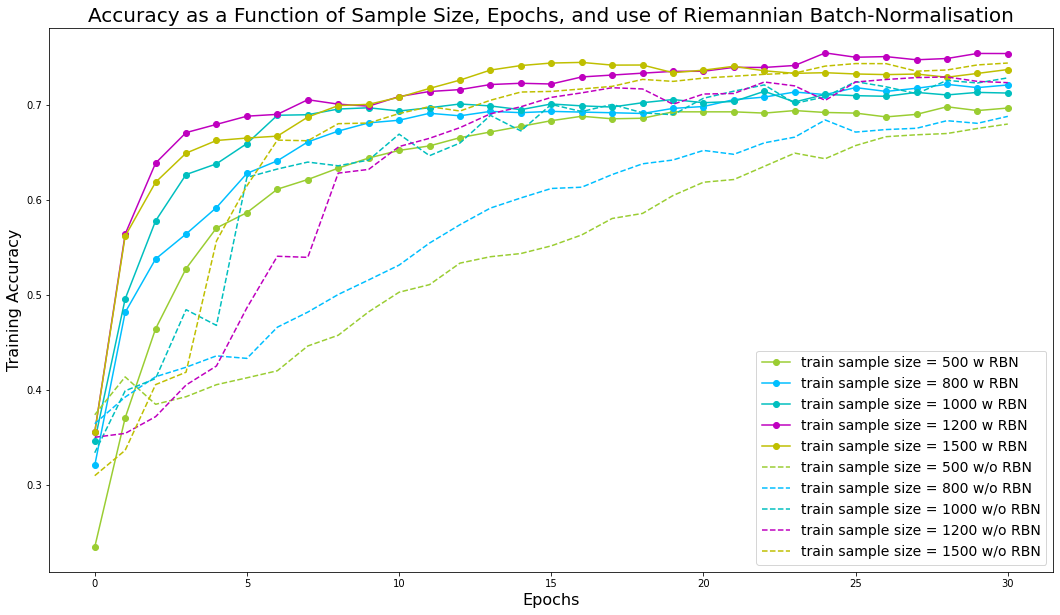

In [12]:
plt.figure(figsize=(18, 10))
#colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
colors = ['yellowgreen', 'deepskyblue', 'c', 'm', 'y', 'k', 'mediumturquoise', 'lightsalmon', 'cornflowerblue', 'gold']
for i, train_size in enumerate(train_sizes):
  plt.plot(acc_results[i, :], '-o', color=colors[i % len(colors)],
           label=f'train sample size = {train_size} w RBN')
for i, train_size in enumerate(train_sizes):
  plt.plot(acc_results[i + len(train_sizes), :], '--',
           color=colors[i % len(colors)],
           label=f'train sample size = {train_size} w/o RBN')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Training Accuracy', fontsize=12)
#plt.title('Accuracy as a Function of Sample Size, Epochs, ' +
          'and use of Riemannian Batch-Normalisation', fontsize=20)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.savefig('accuracy_plot_top60_both_500.png', bbox_inches='tight')
plt.show()

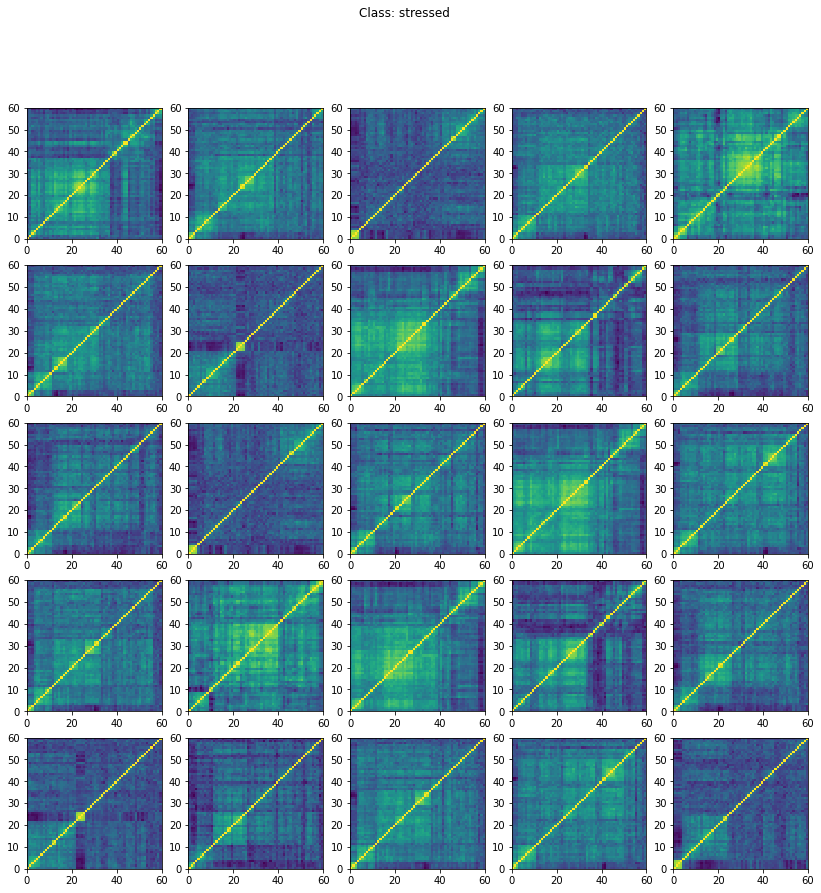

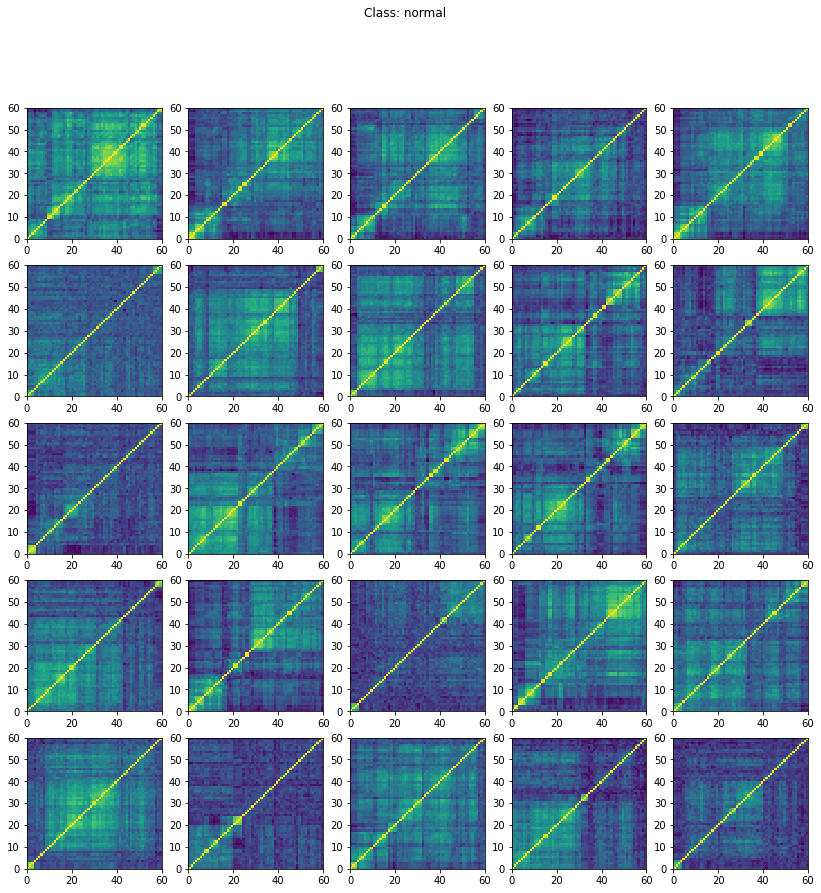

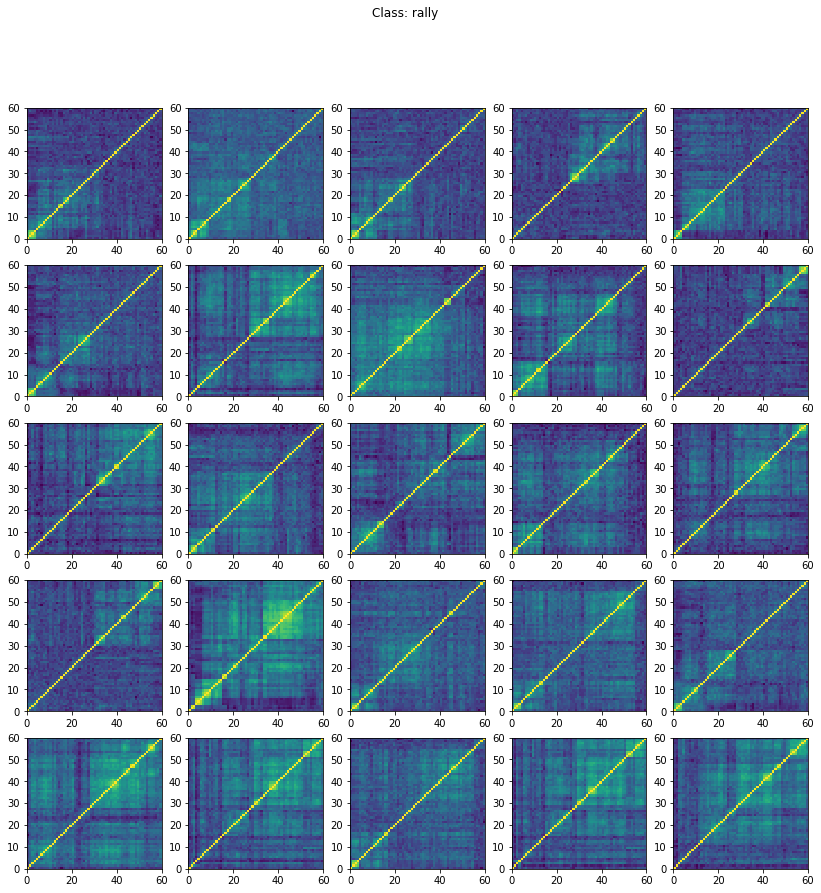

In [13]:
for id_class, regime in enumerate(['stressed', 'normal', 'rally']):
  plt.figure(figsize=(14, 14))
  count = 0
  for pt in train_set:
    if pt[1] == id_class:
      plt.subplot(5, 5, count + 1)
      plt.pcolormesh(pt[0][0, :, :])
      count += 1
      if count >= 25:
        break
  plt.suptitle(f'Class: {regime}', fontsize=12)
  plt.show()

In [14]:
train_size = 1500

# Create dataset instances
train_set = DatasetCorrMats(shuffled_matrices[:train_size], shuffled_labels[:train_size])
test_set = DatasetCorrMats(shuffled_matrices[-1500:], shuffled_labels[-1500:])

# DataLoader instances
train_generator = data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_generator = data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

test_accuracy, model = train_model(train_generator, test_generator, use_rbn=True)

Initial validation accuracy: 33.74%
Val acc: 71.04% at epoch 10/30
Val acc: 72.97% at epoch 20/30
Val acc: 73.62% at epoch 30/30


In [15]:
predictions = []
for i in range(len(test_set)):
  t = test_set[i][0].reshape(1, 1, 60, 60)
  out = model(t)
  predictions.append(out.detach().numpy()[0].tolist())
predictions = pd.DataFrame(predictions,
                           columns=['stressed', 'normal', 'rally'])

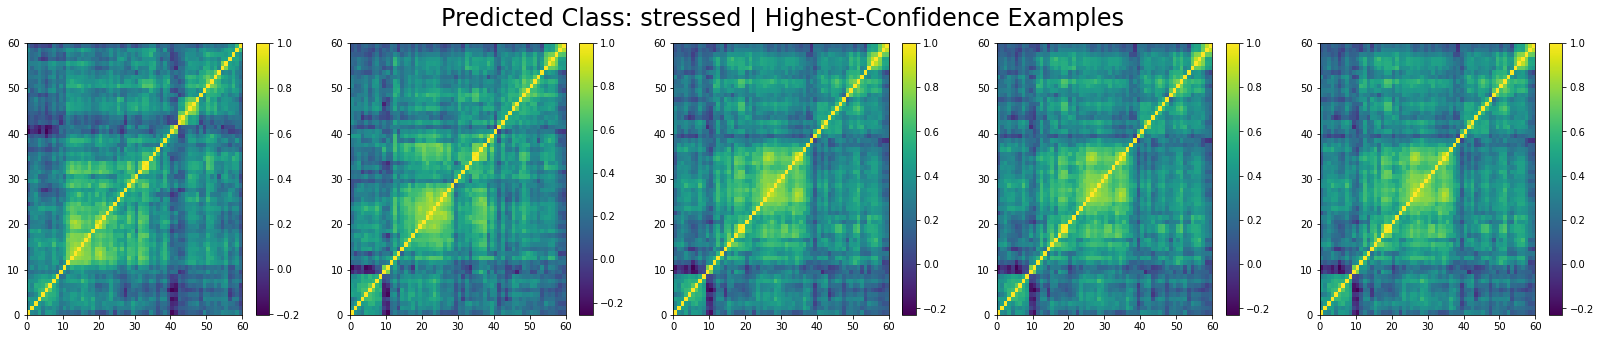

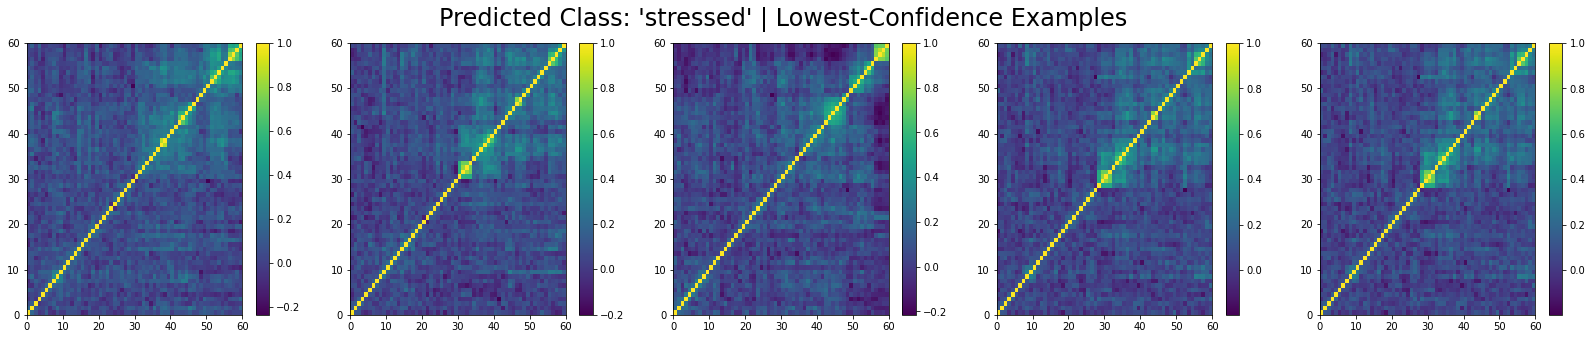

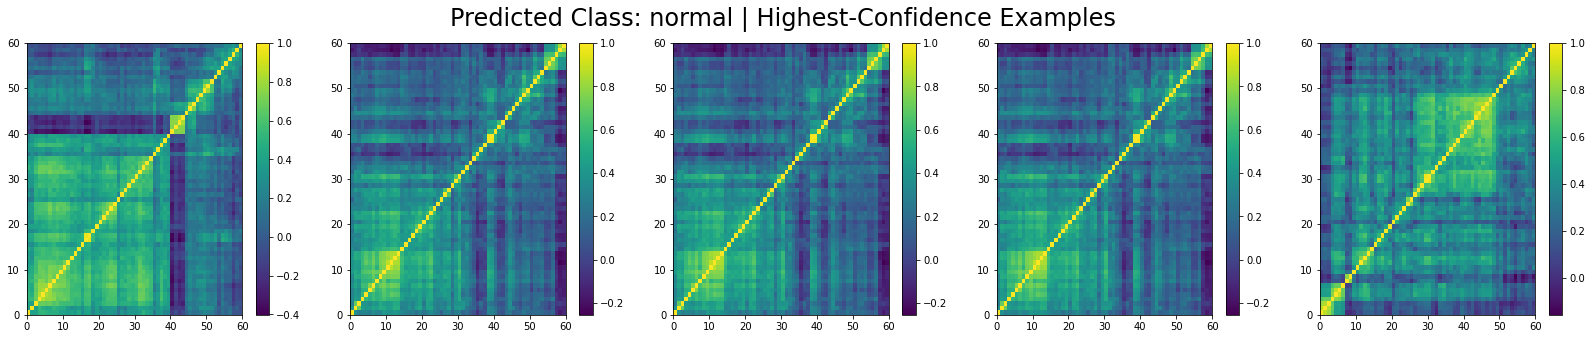

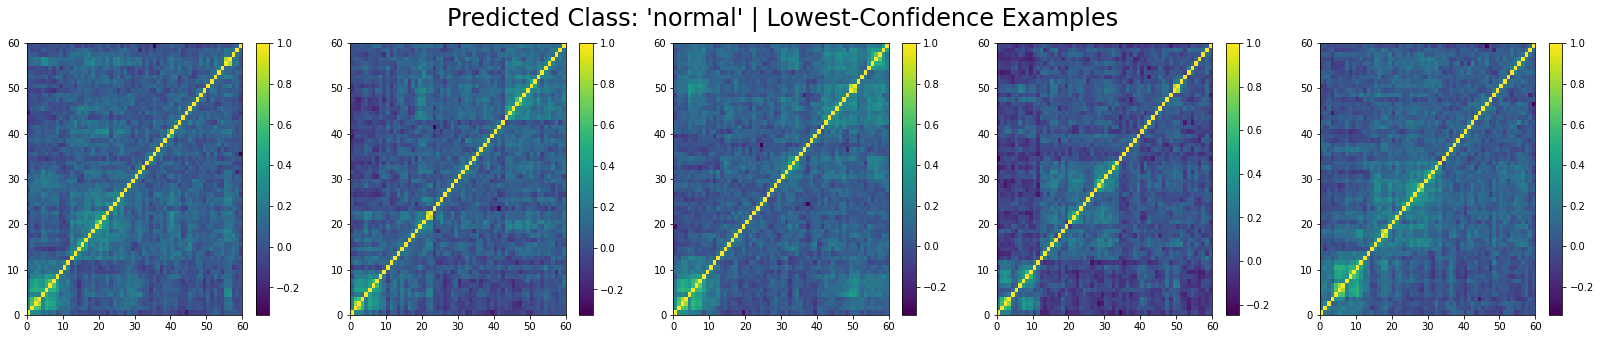

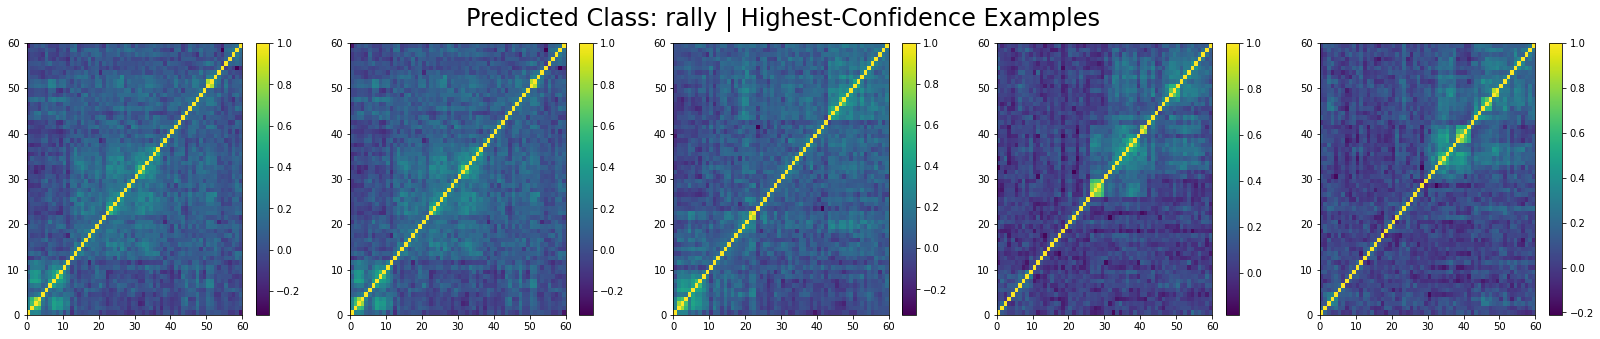

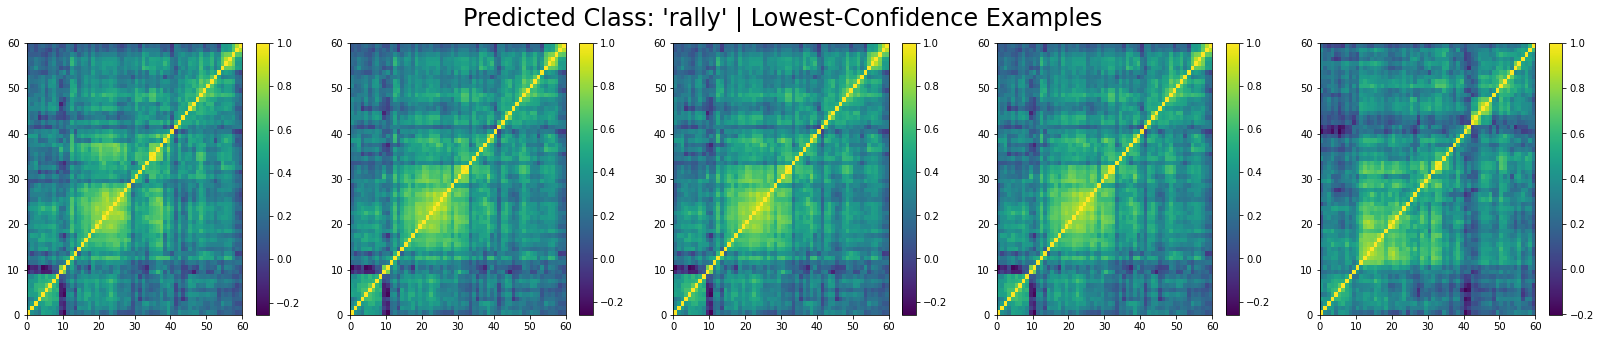

In [16]:
for cur_class in ['stressed', 'normal', 'rally']:
  most_typical = (predictions
                  .sort_values(cur_class, ascending=False)
                  .head(5)
                  .index)
  plt.figure(figsize=(28, 5))
  for i, idx in enumerate(most_typical):
    plt.subplot(1, 5, i + 1)
    plt.pcolormesh(test_set[idx][0][0, :, :])
    plt.colorbar()
  plt.suptitle(f'Predicted Class: {cur_class} | Highest-Confidence Examples',
              fontsize=24)
  plt.show()

  less_typical = (predictions
                  .sort_values(cur_class, ascending=False)
                  .tail(5)
                  .index)
  plt.figure(figsize=(28, 5))
  for i, idx in enumerate(less_typical):
    plt.subplot(1, 5, i + 1)
    plt.pcolormesh(test_set[idx][0][0, :, :])
    plt.colorbar()
  plt.suptitle(f"Predicted Class: '{cur_class}' | Lowest-Confidence Examples",
              fontsize=24)
  plt.show()